In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pyuvdata import UVData, UVCal
# import glob
# import aipy
from hera_qm import ant_metrics
import hera_cal.abscal as abscal
from hera_cal import omni, utils, firstcal, datacontainer, redcal
# from matplotlib.colors import LogNorm
# import sys
from copy import deepcopy
import omnical
import uvtools as uvt
%matplotlib notebook

In [2]:
#hardcoded bad ants
#model_bad_ants = [0, 2, 11, 14, 50, 98, 26, 84, 121]
model_bad_ants = [0, 2, 11, 14, 98, 26, 84, 121] 
#50 is flagged in data, so ok to include in model

In [3]:
pols = ['xx']
raw_data_file = '../H1C_Data/zen.2458043.12552.xx.HH.uv'
ant_metrics_json = '../H1C_Data/zen.2458043.12552.HH.uv.ant_metrics.json'
fc_file = '../H1C_Data/zen.2458043.12552.xx.HH.uv.first.calfits'
abscal_modelfiles = ['../H1C_Data/zen.2458042.12552.xx.HH.uvX',
                    '../H1C_Data/zen.2458042.13298.xx.HH.uvX']
omnical_datafile = '../H1C_Data/zen.2458043.12552.xx.HH.uvOR'

In [4]:
am = ant_metrics.load_antenna_metrics(ant_metrics_json)
ex_ants = list(set([ant[0] for ant in am['xants']]))

In [5]:
uvd = UVData()
uvd.read_miriad(raw_data_file)

In [6]:
aa = utils.get_aa_from_uv(uvd)
info = omni.aa_to_info(aa, pols=['x'], crosspols=['xx'])#, ex_ants=ex_ants)
reds = info.get_reds()

In [7]:
data, flags, antpos, ants, freqs, times, lsts, pols = abscal.UVData2AbsCalDict(raw_data_file, pop_autos=False, return_meta=True)

<IPython.core.display.Javascript object>


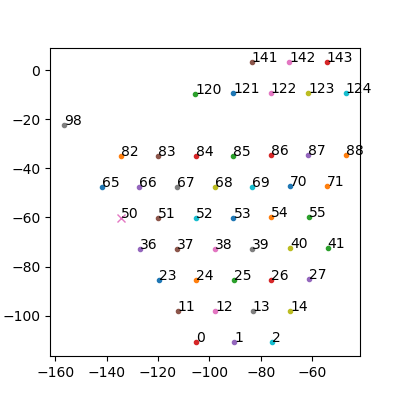

In [8]:
plt.figure(figsize=(4,4))
for ant, pos in antpos.items():
    if ant in ex_ants:
        plt.plot(pos[0],pos[1],'x')
    else: 
        plt.plot(pos[0],pos[1],'.')       
    plt.text(pos[0], pos[1], str(ant))

In [9]:
for i,red in enumerate(reds): 
    if len(red) > 20: print i,len(red), red[0], antpos[red[0][0]] - antpos[red[0][1]], np.linalg.norm(antpos[red[0][0]] - antpos[red[0][1]])
redToPlot = reds[84]

redToPlot = [(i,j) for (i,j) in redToPlot if i not in model_bad_ants and j not in model_bad_ants]
redToPlot = redToPlot[0:15]
print redToPlot, len(redToPlot), np.linalg.norm(antpos[redToPlot[0][0]] - antpos[redToPlot[0][1]])

5 37 (0, 1) [ -1.46078427e+01  -5.57885274e-02   9.77542516e-03] 14.607952464
19 22 (1, 23) [ 29.31231569 -25.19203311   0.28009356] 38.6513756041
22 25 (11, 51) [  7.44888475 -37.93252111   0.44966296] 38.6595943927
26 27 (12, 26) [-21.86342673 -12.74048793   0.06951876] 25.3048274811
32 23 (23, 68) [-21.76683698 -38.03408935   0.46923103] 43.824734141
38 33 (0, 11) [  7.35221754 -12.6189084    0.14991779] 14.6052876516
42 29 (12, 38) [  0.09663295 -25.30360649   0.15966136] 25.3042947146
44 33 (0, 12) [ -7.25562582 -12.67469765   0.21967651] 14.6061741806
48 23 (0, 36) [ 22.05668928 -37.86672947   0.45985386] 43.8246301568
52 22 (1, 27) [-29.11905036 -25.41518368   0.17926212] 38.6507799375
56 26 (14, 55) [ -7.15895313 -37.98830699   0.43945511] 38.6594774725
70 27 (1, 11) [ 21.9600602  -12.56311988   0.14014237] 25.3001159099
74 27 (2, 27) [-14.51120795 -25.35939515   0.16945327] 29.2181928427
84 28 (0, 23) [ 14.70447303 -25.24782164   0.28986898] 29.2191383983
86 28 (69, 71) [-29.2

In [10]:
red_data = deepcopy(data)
for (i,j,pol) in red_data.keys():
    if (i,j) not in redToPlot:
        del red_data[(i,j,pol)] 

# Plotting

In [11]:
def plot_reds(dc, redToPlot, cbarlabel, ncol=3):
    with plt.style.context(('dark_background')):
    #with plt.style.context(('classic')):
        fig, axes = plt.subplots(len(redToPlot)/ncol, ncol, sharex=True, sharey=True, figsize = (10,6))
        for i,(bl, ax) in enumerate(zip(redToPlot, axes.flatten())):
            im = ax.imshow(np.angle(dc[bl]['xx']), cmap='inferno', aspect='auto', extent=[100,200,51,0])
            ax.text(101-.2,48-.7,str(bl), color='k', fontsize = 16)
            ax.text(101,48,str(bl), color='w', fontsize = 16)
            if i >= len(axes.flatten())-ncol:
                ax.set_xlabel('Frequency (MHz)', size=14)
            ax.set_yticks([])
            ax.tick_params(labelsize=14)
        plt.tight_layout()
        cbar = fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal', label=cbarlabel, aspect=40)
        cbar.ax.xaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=14))
        cbar.ax.tick_params(labelsize=14) 

# Raw Data

<IPython.core.display.Javascript object>


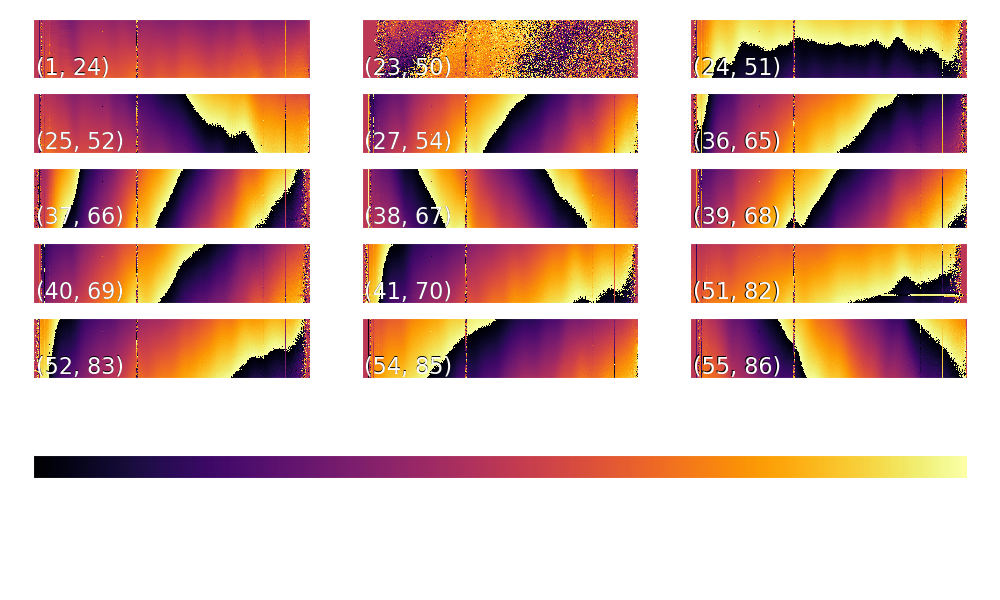

In [12]:
plot_reds(red_data, redToPlot, 'Phase of Uncalibrated Visibilities for a 29 m Redundant Baseline')
plt.savefig('raw.pdf')

# ex_ants

In [13]:
red_data_ex_ant = deepcopy(red_data)
for (i,j,pol) in red_data_ex_ant.keys():
    if i in ex_ants or j in ex_ants:
        red_data_ex_ant[(i,j,pol)] = np.zeros_like(red_data_ex_ant[(i,j,pol)])

<IPython.core.display.Javascript object>


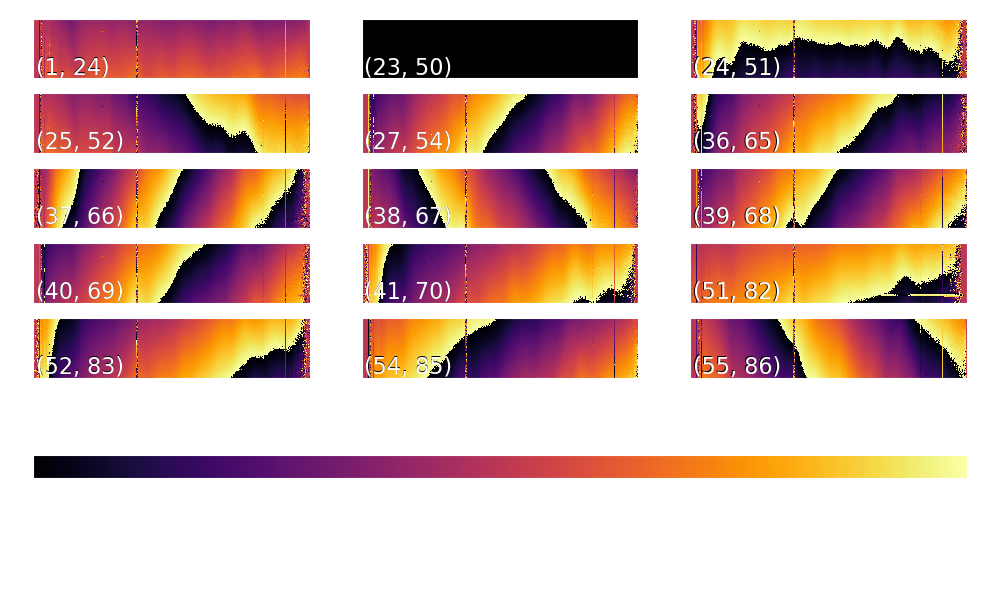

In [14]:
plot_reds(red_data_ex_ant, redToPlot,'Phase of Uncalibrated Visibilities for a 29 Redundant Baseline')
plt.savefig('ex_ants.pdf')

# Perform Firstcal

../H1C_Data/zen.2458043.12552.xx.HH.uv.first.calfits appears to be an old calfits format which has been depricated. Rewrite this file with write_calfits to ensure future compatibility.


<IPython.core.display.Javascript object>


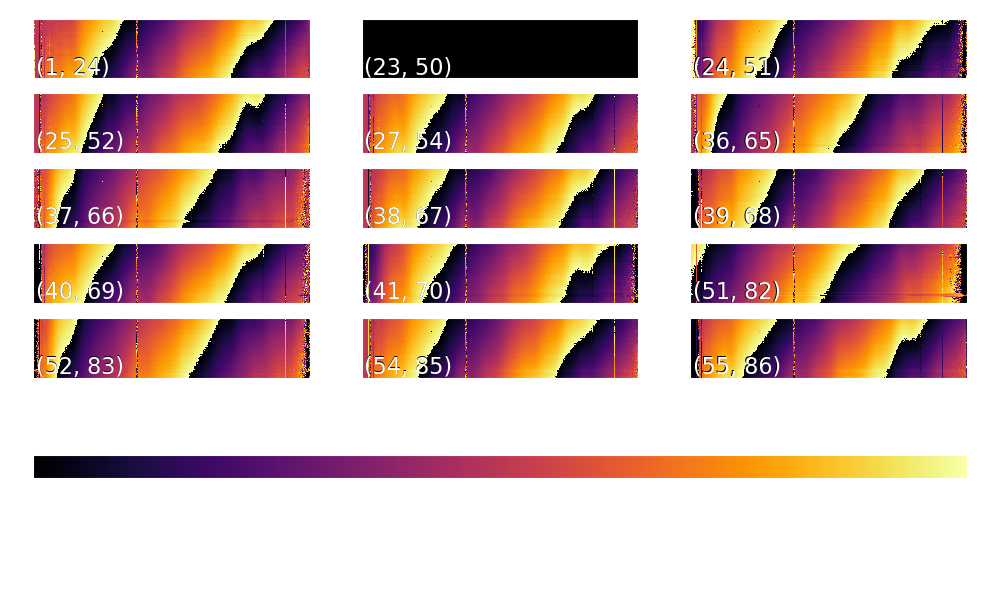

In [15]:
fc = UVCal()
fc.read_calfits(fc_file)
fc_x_gains = {ant: fc.gain_array[i,0,:,:,0].T for i,ant in enumerate(fc.ant_array)}

red_data_fc = deepcopy(red_data_ex_ant)
for (i,j,pol) in red_data_fc.keys():
    if i not in ex_ants and j not in ex_ants:
        red_data_fc[(i,j,pol)] = red_data_fc[(i,j,pol)] / fc_x_gains[i] / np.conj(fc_x_gains[j])
plot_reds(red_data_fc, redToPlot,'Phase of Delay-Calibrated Visibilities for a 29 m Redundant Baseline')
plt.savefig('fc.pdf')

# to_flip = [65, 66]
# red_data_flipped = deepcopy(red_data_fc)
# for (i,j,pol) in red_data_fc.keys():
#     if i in to_flip or j in to_flip:
#         red_data_flipped[(i,j,pol)] *= -1
# plot_reds(red_data_flipped, redToPlot,'title')#'Phase of Delay-Calibrated Visibilities for the 29.4 m EW Baseline')
# # plt.savefig('fc_flipped.pdf')


# Perform Omnical

In [16]:
_, g0, _, _ = omni.from_fits(fc_file) #check and see if this is the same as aaron

../H1C_Data/zen.2458043.12552.xx.HH.uv.first.calfits


In [17]:
datapack, wgtpack = firstcal.UVData_to_dict([uvd])
for bl in datapack.keys():
    for pol in datapack[bl].keys():
        datapack[bl][pol] = np.array(datapack[bl][pol], dtype=np.complex64)
for antpol in g0.keys():
    for ant in g0[antpol].keys():
        g0[antpol][ant] = np.array(g0[antpol][ant], dtype=np.complex64)        

In [18]:
info = omni.aa_to_info(aa, pols=['x'], crosspols=['xx'], ex_ants=ex_ants)

In [19]:
#takes about 30s
m1, g1, v1 = omnical.calib.logcal(datapack, info, gains=g0)

In [20]:
#takes about 3.5min
m2, g2, v2 = omnical.calib.lincal(datapack, info, gains=g1, vis=v1)

In [21]:
g3, v3 = omni.remove_degen(info, g2, v2, g0, minV=False)

<IPython.core.display.Javascript object>


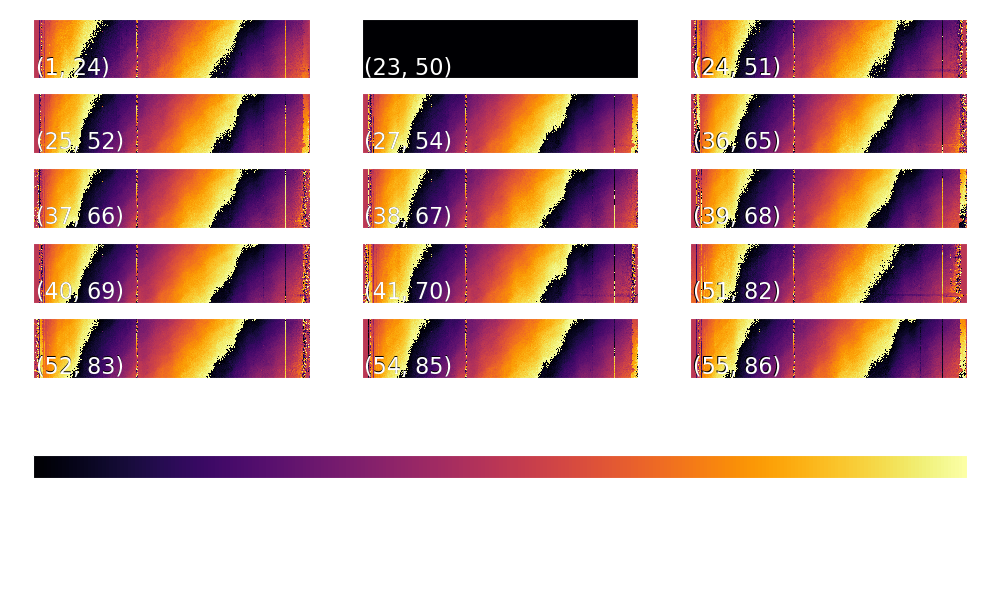

In [22]:
red_data_omni = deepcopy(red_data_ex_ant)
for (i,j,pol) in red_data_omni.keys():
    if i not in ex_ants and j not in ex_ants:
        red_data_omni[(i,j,pol)] = red_data_omni[(i,j,pol)] / g1['x'][i] / np.conj(g1['x'][j])
plot_reds(red_data_omni, redToPlot,'Phase of Redundant-Calibrated Visibilities for a 29 m Redundant Baseline')
plt.savefig('log.pdf')

<IPython.core.display.Javascript object>


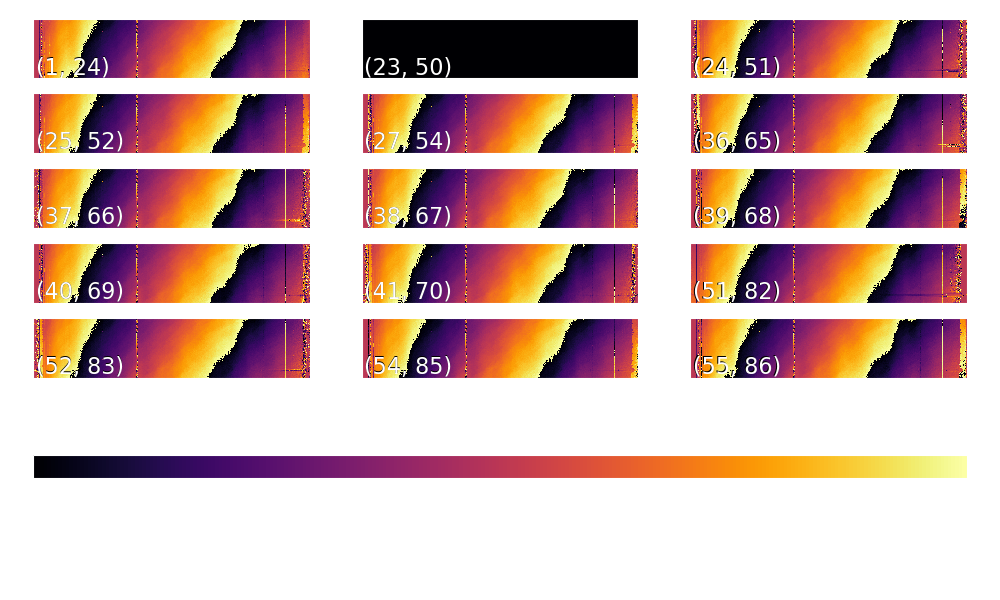

In [23]:
red_data_omni = deepcopy(red_data_ex_ant)
for (i,j,pol) in red_data_omni.keys():
    if i not in ex_ants and j not in ex_ants:
        red_data_omni[(i,j,pol)] = red_data_omni[(i,j,pol)] / g2['x'][i] / np.conj(g2['x'][j])
plot_reds(red_data_omni, redToPlot,'Phase of Redundant-Calibrated Visibilities for a 29 m Redundant Baseline')
plt.savefig('oc.pdf')

<IPython.core.display.Javascript object>


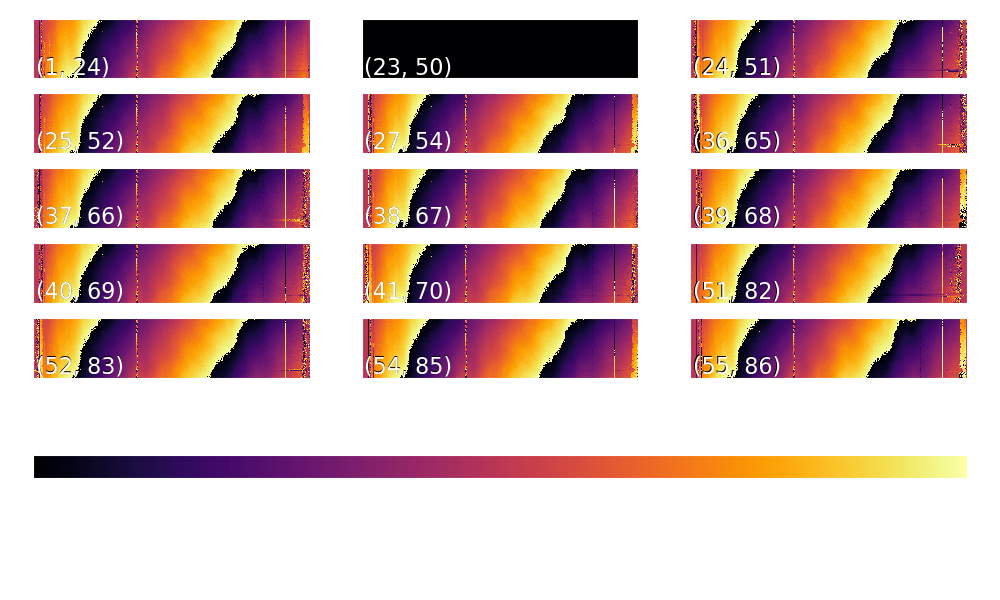

In [24]:
red_data_rd = deepcopy(red_data_ex_ant)
for (i,j,pol) in red_data_rd.keys():
    if i not in ex_ants and j not in ex_ants:
        red_data_rd[(i,j,pol)] = red_data_rd[(i,j,pol)] / g3['x'][i] / np.conj(g3['x'][j])
plot_reds(red_data_rd, redToPlot,'Phase of Redundant-Calibrated Visibilities for a 29 m Redundant Baseline')
plt.savefig('rd.pdf')

# Abscal

In [25]:
# specify model file and load into UVData, load into dictionary
(model, mflags, antpos, ants, model_freqs, model_times, model_lsts, 
 model_pols) = abscal.UVData2AbsCalDict(abscal_modelfiles, return_meta=True)

In [26]:
for (i,j,pol) in model.keys():
    if i in model_bad_ants or j in model_bad_ants:
        del model[(i,j,pol)]

In [27]:
# specify data file and load into UVData, load into dictionary
(data, dflags, antpos, ants, data_freqs, data_times, data_lsts, 
 data_pols) = abscal.UVData2AbsCalDict(omnical_datafile, return_meta=True)

# make wgts
wgts = deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)


In [28]:
# plot_reds(data, redToPlot,'title')#'Phase of Delay-Calibrated Visibilities for the 29.4 m EW Baseline')
# plt.savefig('data_input_to_abscal')

In [29]:
# plot_reds(model, redToPlot,'title')#'Phase of Delay-Calibrated Visibilities for the 29.4 m EW Baseline')
# plt.savefig('model_before_interp')

In [30]:
model, interp_flags = abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs)

In [31]:
# plot_reds(model, redToPlot,'title')#'Phase of Delay-Calibrated Visibilities for the 29.4 m EW Baseline')
# plt.savefig('model')

In [32]:
# # instantiate class
AC = abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [33]:
# # plot data
# bl = (24, 54, 'xx')
# fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# plt.sca(axes[0])
# uvt.plot.waterfall(AC.data[bl], mode='log', mx=1, drng=2)
# plt.colorbar()
# plt.title('data AMP {}'.format(bl))
# plt.sca(axes[1])
# uvt.plot.waterfall(AC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
# plt.colorbar()
# plt.title('data PHS {}'.format(bl))

In [34]:
# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
#takes about 1 min
AC.delay_slope_lincal(time_avg=True)

...configuring linsolve data for delay_lincal


invalid value encountered in divide
invalid value encountered in double_scalars
divide by zero encountered in divide


...running linsolve
...finished linsolve


<IPython.core.display.Javascript object>


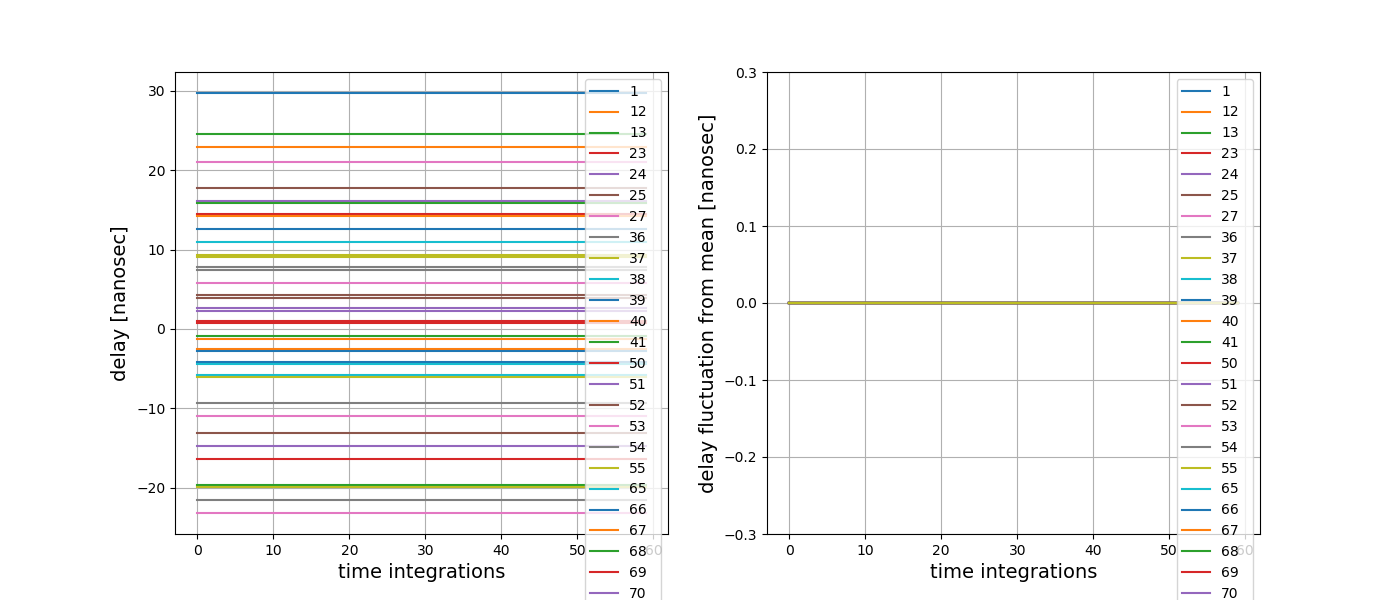

(-0.3, 0.3)

In [35]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.dly_slope_ant_dly_arr[:, :, 0, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)
ax.set_ylim(-0.3, 0.3)

In [36]:
# apply to data
data_gain_keys = [(i,'x') for i in {i for i,j in data.bls()} | {j for i,j in data.bls()}]
delay_slope_gains = AC.custom_dly_slope_gain(data_gain_keys, antpos)
delay_corr_data = abscal.apply_gains(AC.data, delay_slope_gains)

<IPython.core.display.Javascript object>


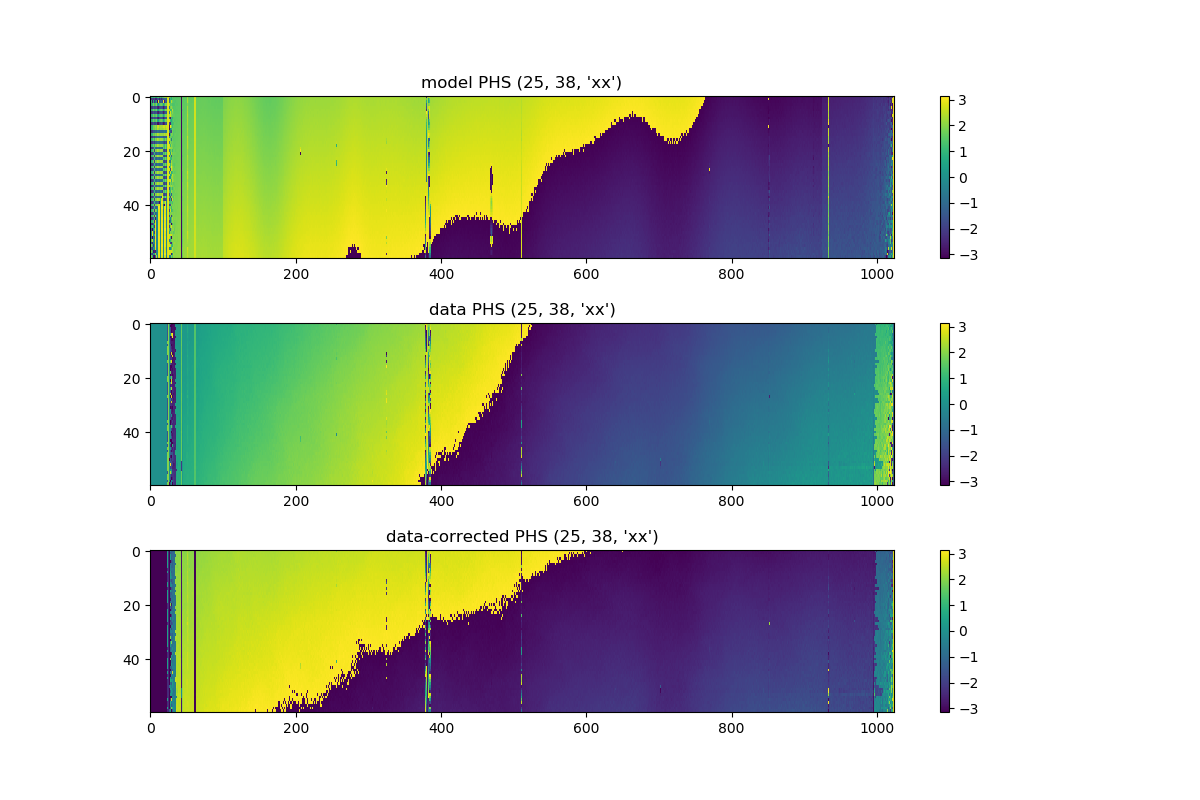

Text(0.5,1,u"data-corrected PHS (25, 38, 'xx')")

In [37]:
# inspect results data
bl = (25, 38, 'xx')
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(delay_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

In [38]:
# plot_reds(delay_corr_data, redToPlot,'title')#'Phase of Delay-Calibrated Visibilities for the 29.4 m EW Baseline')
#plt.savefig('delay_corr_data')

In [39]:
# # instantiate class
# DAC = abscal.AbsCal(model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [40]:
# # avg phase solver
# # Takes 7.5 min
# DAC.phs_logcal(avg=True)

In [41]:
# # apply to data
# dly_phs_corr_data = abscal.apply_gains(DAC.data, (DAC.ant_phi_gain))

In [42]:
# plot_reds(dly_phs_corr_data, redToPlot,'title')#'Phase of Delay-Calibrated Visibilities for the 29.4 m EW Baseline')
# plt.savefig('dly_phs_corr_data')

In [43]:
# instantiate class
DPAC = abscal.AbsCal(model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [44]:
# run amp linsolve
# takes about 30 sec
DPAC.abs_amp_logcal()

...configuring linsolve data for abs_amp_logcal


divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in divide


...running linsolve
...finished linsolve


In [45]:
# run phs linsolve
# takes about 1 min
DPAC.TT_phs_logcal(zero_psi=False, four_pol=False)

...configuring linsolve data for TT_phs_logcal


invalid value encountered in divide
divide by zero encountered in divide


...running linsolve
...finished linsolve


In [46]:
gain_parts = (DPAC.custom_abs_psi_gain(data_gain_keys), 
              DPAC.custom_TT_Phi_gain(data_gain_keys, antpos), 
              DPAC.custom_abs_eta_gain(data_gain_keys))
# apply to data
abs_corr_data = abscal.apply_gains(DPAC.data, gain_parts, gain_convention='divide')

In [47]:
rfi_red_data = deepcopy(data)
for (i,j,pol) in rfi_red_data.keys():
    if (i,j) not in redToPlot:
        del rfi_red_data[(i,j,pol)]
    else:
        rfi_red_data[(i,j,pol)][:,0:100] = -1-1e-16j
        rfi_red_data[(i,j,pol)][:,-100:] = -1-1e-16j
        if i in ex_ants or j in ex_ants:
            rfi_red_data[(i,j,pol)][:,:] = -1-1e-16j
        rfi_red_data[(i,j,pol)][dflags[(i,j,pol)]] = -1-1e-16j

<IPython.core.display.Javascript object>


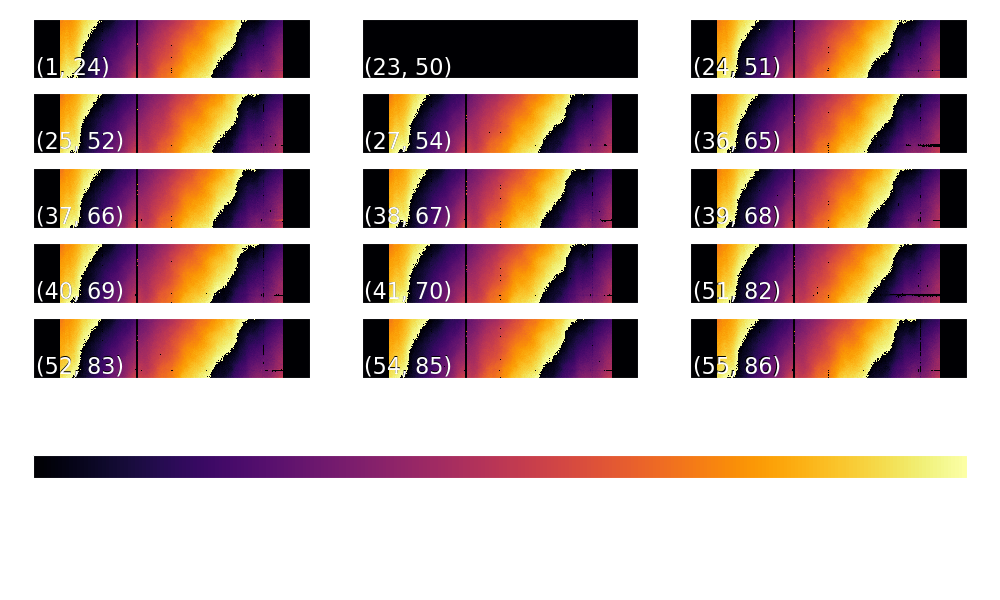

In [48]:
plot_reds(rfi_red_data, redToPlot,'Phase of RFI-flagged Visibilities for a 29 m Redundant Baseline')
plt.savefig('rfi.pdf')

In [49]:
abs_corr_red_data = deepcopy(abs_corr_data)
for (i,j,pol) in abs_corr_red_data.keys():
    if (i,j) not in redToPlot:
        del abs_corr_red_data[(i,j,pol)]
    else:
        abs_corr_red_data[(i,j,pol)][:,0:100] = -1-1e-16j
        abs_corr_red_data[(i,j,pol)][:,-100:] = -1-1e-16j
        if i in ex_ants or j in ex_ants:
            abs_corr_red_data[(i,j,pol)][:,:] = -1-1e-16j
        abs_corr_red_data[(i,j,pol)][dflags[(i,j,pol)]] = -1-1e-16j

<IPython.core.display.Javascript object>


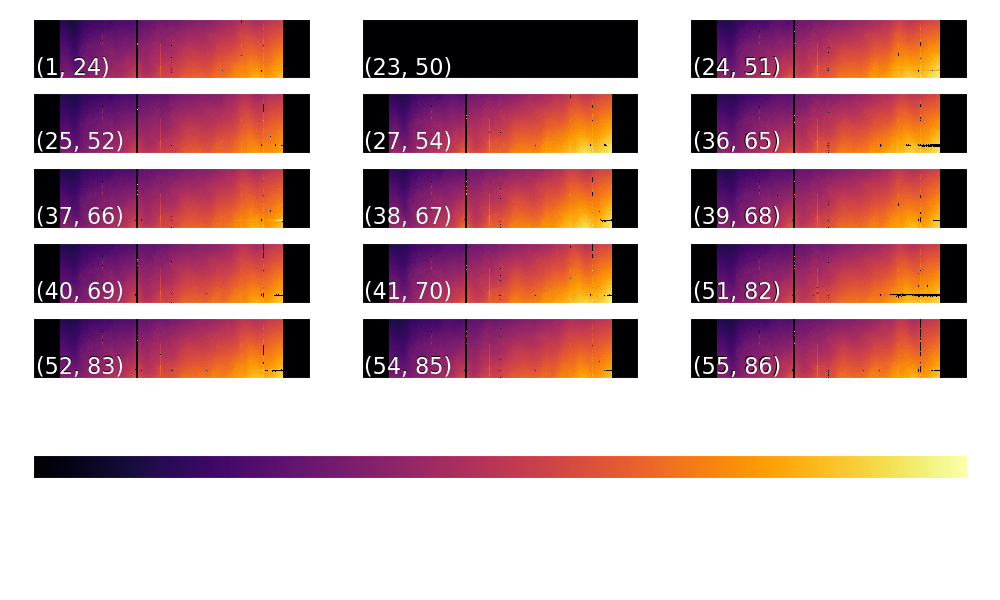

In [50]:
plot_reds(abs_corr_red_data, redToPlot,'Phase of Absolute-Calibrated Visibilities for a 29 m Redundant Baseline')
plt.savefig('abscal.pdf')

# Plot full gains

In [51]:
abscal_gain_sets = [AC.custom_dly_slope_gain(data_gain_keys, antpos), 
                    DPAC.custom_abs_psi_gain(data_gain_keys), 
                    DPAC.custom_TT_Phi_gain(data_gain_keys, antpos), 
                    DPAC.custom_abs_eta_gain(data_gain_keys)]

In [52]:
g_dly = {}
for (ant,pol) in data_gain_keys:
    if ant not in model_bad_ants and ant not in ex_ants:
        g_dly[(ant,pol)] = deepcopy(g0[pol][ant])
for gain in [AC.custom_dly_slope_gain(data_gain_keys, antpos)]:
    for (ant,pol) in data_gain_keys:
        if ant not in model_bad_ants and ant not in ex_ants:
            g_dly[(ant,pol)] *= gain[(ant,pol)]

In [53]:
g_abs = {}
for (ant,pol) in data_gain_keys:
    if ant not in model_bad_ants and ant not in ex_ants:
        g_abs[(ant,pol)] = deepcopy(g3[pol][ant])
for gain in abscal_gain_sets:
    for (ant,pol) in data_gain_keys:
        if ant not in model_bad_ants and ant not in ex_ants:
            g_abs[(ant,pol)] *= gain[(ant,pol)]

<IPython.core.display.Javascript object>


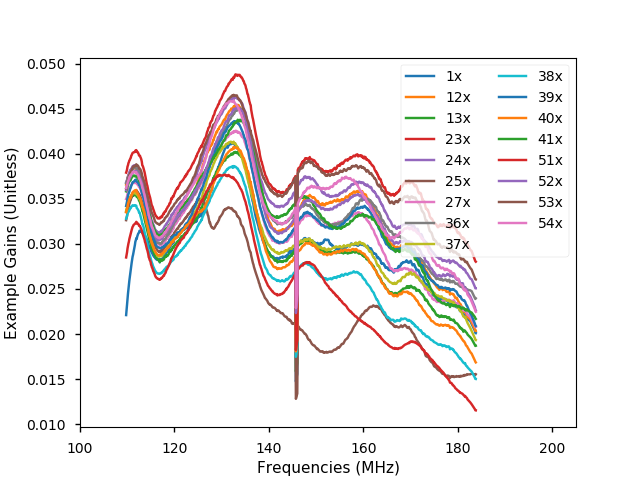

In [54]:
plt.figure()
start = 100
stop = 1024-80
flag_sum = np.sum([dflags[k] for k in dflags.keys()],axis=(0,1))
unflagged = flag_sum < .045*np.max(flag_sum)
unflagged[:start] = False
unflagged[stop:] = False
#with plt.style.context(('dark_background')):
with plt.style.context(('seaborn-notebook')):
    for ant in data_gain_keys[0:23]:
        try:
            plt.plot(freqs[unflagged]/1e6, np.abs(np.mean(g_abs[ant].T,axis=1))[unflagged], label=str(ant[0])+ant[1])
            #plt.plot(freqs[unflagged]/1e6, np.abs(np.mean(g3['x'][ant[0]].T,axis=1))[unflagged], label=str(ant[0])+ant[1])
        except:
            pass
    plt.xlim([100,205])
    #plt.ylim([.5,1.5])
    plt.ylabel('Example Gains (Unitless)')
    plt.xlabel('Frequencies (MHz)')
    plt.legend(ncol=2)
    plt.savefig('average_gains.pdf')

# Export complete calibration solution

In [55]:
def synthesize_ant_flags(flags, ants):
    '''If the data is flagged for any visibility the antenna is involved in, the antenna is also flagged.'''
    ant_flags = {}
    for (ant,antpol) in ants:
        ant_flags[(ant,antpol)] = np.zeros(flags[flags.keys()[0]].shape, dtype=bool)
        for (i,j,pol) in flags.keys():
            if ant == i or ant == j:
                if not np.all(flags[(i,j,pol)]):
                    ant_flags[(ant,antpol)] += flags[(i,j,pol)]
    return ant_flags

ant_flags = synthesize_ant_flags(dflags, g_abs.keys())

In [64]:
cal = UVCal()
cal.read_calfits('../H1C_Data/zen.2458043.12552.HH.uv.omni.calfits')
ants_to_keep = [ant for (ant,pol) in data_gain_keys if ant not in model_bad_ants and ant not in ex_ants]
cal.select(jones=[-5]) # this is 'x' because pol2str = {-5:"x", -6:"y"}
cal.select(antenna_nums = ants_to_keep)
for i,ant in enumerate(cal.ant_array):
    cal.gain_array[i][0,:,:,0] = g_abs[(ant,'x')].T
    cal.flag_array[i][0,:,:,0] = ant_flags[(ant,'x')].T

cal.cal_style='redundant'
cal.history = 'Absolute calibration solution (first+omni+abs) for a subset of antennas using \
Abscal_Omnical_Demonstration_Plots.ipynb (unofficial and not for pipeline use).' + cal.history
cal.write_calfits('../H1C_Data/zen.2458043.12552.xx.HH.uv.abs_josh.calfits', clobber=True)

In [65]:
cal = UVCal()
cal.read_calfits('../H1C_Data/zen.2458043.12552.HH.uv.omni.calfits')
ants_to_keep = [24]
cal.select(jones=[-5]) # this is 'x' because pol2str = {-5:"x", -6:"y"}
cal.select(antenna_nums = ants_to_keep)
for i,ant in enumerate(cal.ant_array):
    cal.gain_array[i][0,:,:,0] = g_abs[(ant,'x')].T
    cal.flag_array[i][0,:,:,0] = ant_flags[(ant,'x')].T
    
cal.cal_style='redundant'
cal.history = 'Absolute calibration solution (first+omni+abs) for a subset of antennas using \
Abscal_Omnical_Demonstration_Plots.ipynb (unofficial and not for pipeline use).' + cal.history
cal.write_calfits('../H1C_Data/zen.2458043.12552.xx.HH.uv.abs_josh_simple.calfits', clobber=True)

In [67]:
test = {}
print test == {}

True


In [70]:
np.arange(10)[~(np.arange(10)<5)]

array([5, 6, 7, 8, 9])

# other stuff

In [58]:
# start = 0
# stop = 1024
# #with plt.style.context(('dark_background')):
# with plt.style.context(('seaborn-notebook')):
#     fig, axes = plt.subplots(2,1,sharex=True, figsize = (10*.8,6*.8))
#     ax = axes[0]
#     for ant in g3['x'].keys():
#         ax.plot(1e3*freqs[start:stop],np.abs(np.mean(g3['x'][ant][0:1,start:stop] / fc_x_gains[ant][0:1,start:stop], axis=0)),label=ant)
#     ax.set_ylim([.5,1.5])
#     ax.set_xlim([100,200])
#     ax.set_ylabel('Gains (Unitless)')
    
#     ax = axes[1]
#     for ant in g3['x'].keys():
#         ax.plot(1e3*freqs[start:stop],np.angle(np.mean(g3['x'][ant][0:1,start:stop] / fc_x_gains[ant][0:1,start:stop], axis=0)),label=ant)
#     ax.set_ylim([-.5,.5])
#     ax.set_xlim([100,200])
#     ax.set_ylabel('Phase (Radians)')
#     ax.set_xlabel('Frequency (MHz)')

# plt.savefig('average_gains.pdf')

In [59]:
# g3['x'].keys()

In [60]:
# for ant in g3['x'].keys():

#     plt.figure()
#     plt.plot(np.mean(datapack[ant,ant]['xx'].T,axis=1))
#     plt.plot(np.abs(np.mean(g3['x'][ant].T,axis=1))**2 * datapack[ant,ant]['xx'].T[:,0])
#     plt.title(ant)

In [61]:
#  print(plt.style.available)

In [62]:
# start = 0
# stop = 1024
# #with plt.style.context(('dark_background')):
# with plt.style.context(('seaborn-notebook')):
#     fig, axes = plt.subplots(2,1,sharex=True, figsize = (10*.8,6*.8))
#     ax = axes[0]
#     for bl in v3['xx'].keys():
#         ax.semilogy(1e3*freqs[start:stop],np.abs(np.mean(v3['xx'][bl][:,start:stop], axis=0)),label=ant)
#     ax.set_ylim([.1,1])
#     ax.set_xlim([100,200])
#     ax.set_ylabel('Mean Visibility Amplitude')
    
#     ax = axes[1]
#     for bl in v3['xx'].keys():
#         ax.plot(1e3*freqs[start:stop],np.angle(np.mean(v3['xx'][bl][:,start:stop], axis=0)),label=ant)
#     ax.set_ylim([-.5,.5])
#     ax.set_xlim([100,200])
#     ax.set_ylabel('Mean Visibility Phase')
#     ax.set_xlabel('Frequency (MHz)')

# #plt.savefig('average_gains.pdf')

In [63]:
# median_vis = np.median([np.abs(dc[key]) for key in dc.keys() if key[2][0]==key[2][1]])
# median_cross = np.median([np.abs(dc[key]) for key in dc.keys() if key[2][0]!=key[2][1]])
# print median_vis, median_cross, median_vis/median_cross